# Data collection

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!python --version

Python 3.9.7


In [3]:
# get data
df = pd.read_csv('data/public_train.csv').append(pd.read_excel('data/warmup_training_dataset.xlsx'))
print(df.shape)
df.head()

(5172, 8)


,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
0,1.0,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",1585945439,19477,378,173.0,0.0
1,2.0,775baa6d037b6d359b229a656eaeaf08,<URL>,1588939166.0,11,5,3,0.0
2,3.0,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,1591405213,48,5,19.0,0.0
3,4.0,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,1592023613,3,0,0.0,0.0
4,5.0,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,1583737358,775,0,54.0,0.0


In [4]:
label_count = df.value_counts('label')
label_count

label
0.0    4238
1.0     934
dtype: int64

In [5]:
# check null value in data
df.isnull().sum()

id                    0
user_name             0
post_message          1
timestamp_post      164
num_like_post       146
num_comment_post     14
num_share_post      929
label                 0
dtype: int64

In [6]:
# check duplicate data
df[df.duplicated('post_message')]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
150,151.0,dd35242704071b7ddf90a8ee90055ec4,<URL>,1588947622.0,87,4,1,0.0
175,176.0,79c2d500763b7f14f2631a8ab6a71ea4,<URL>,1588917759.0,NaN,0,NaN,0.0
178,179.0,59fb67d9b2bd2b380529562035b3bab4,<URL>,1587632107.0,3,2,NaN,0.0
197,198.0,ae7c1d8434b0629a83958eac387e7424,Cơ hội có 1-0-2 để cùng nhau xây dựng những cô...,1584262049,2898,50,142.0,0.0
454,455.0,654d291ef3011072e7980e89293fbdac,<URL>,1592663724.0,4,0,NaN,0.0
...,...,...,...,...,...,...,...,...
769,769.0,297491051505678016.0,"“Giữa đại dịch virus corona, Thủ tướng Nhật Ab...",1589347145.0,126.0,7.0,17.0,0.0
776,776.0,896764849329199104.0,Bí thư Vương Đình Huệ cho biết Hà Nội đặt mục ...,1588689342.0,5.0,0.0,2.0,0.0
784,784.0,-6167405391948957696.0,TAND Cấp cao tại TP HCM đã kháng nghị Giám đốc...,1591367541.0,49.0,3.0,10.0,0.0
788,788.0,3380755255845678080.0,"Hướng về Hà Nội ❤\n\nSáng nay 7-3, Ban Chỉ đạo...",1583553093.0,30.0,4.0,6.0,0.0


In [7]:
# convert unknown record to 0 value
df.iloc[:, 4:7] = df.iloc[:, 4:7].replace('unknown', 0)

# cast from Dtype object to int64 
for i in range(3, 7):
  df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='coerce', downcast='integer')
  
# convert timestamp to date format
df['timestamp_post'] = pd.to_datetime(df['timestamp_post'], unit='s', errors='coerce')

In [8]:
# remove null, duplicate text content record
df = df.dropna(subset=['post_message'])
df['timestamp_post'] = df['timestamp_post'].fillna(pd.Timestamp(0)) # empty timestamp
df = df.fillna(0)
df = df.drop_duplicates(subset='post_message', keep='first')

# convert dtype of num_like, comment, share feature to int64
df.iloc[:, 4:8] = df.iloc[:, 4:8].astype('int64')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4868 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4868 non-null   float64       
 1   user_name         4868 non-null   object        
 2   post_message      4868 non-null   object        
 3   timestamp_post    4868 non-null   datetime64[ns]
 4   num_like_post     4868 non-null   int64         
 5   num_comment_post  4868 non-null   int64         
 6   num_share_post    4868 non-null   int64         
 7   label             4868 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 342.3+ KB


# TF-IDF features

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyvi import ViTokenizer
import time
import string

In [11]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("data/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [12]:
# get stopwords list
f = open('data/vietnamese-stopwords-dash.txt', 'r', encoding="utf8")
stopwords = f.read().split('\n')

# remove stopwords in news text
def clean_stopwords(text_list):
  ''' sent_list: already tokenized text in list type
  '''
  clean_text = []
  for word in text_list:
    if word not in stopwords:
      clean_text.append()
  return clean_text

def tokenize(text):
  text = text.translate(str.maketrans('', '', string.punctuation)) # clean punctuation
  text = rdrsegmenter.tokenize(text.lower())
  return text[0]

In [13]:
start = time.time()

# get tfidf vectors with n_gram = 2
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2), max_features=50000)
X_tfidf = vectorizer.fit_transform(df['post_message'])

end = time.time()
print(end - start)

35.11665344238281


In [14]:
# reduce dimensionality of tfidf vector to 100 dimensions as recommended for tfidf
svd = TruncatedSVD(n_components=100, algorithm='arpack')
X_tfidf_svd = svd.fit_transform(X_tfidf)

In [15]:
# scale data to (0, 1) range as we've performed dimension reduction
scaler1 = MinMaxScaler()
X1 = scaler1.fit_transform(X_tfidf_svd)

# Custom features

In [16]:
def extract_feature(data):
  
  text = data[2] # get text content
  
  num_punct, num_one, num_two, num_three_gtt, \
  num_numbers, num_stopwords, \
  num_upper, num_any_upper, num_hashtag, \
  num_N , num_V, num_A, num_url = [0]*13
  
  tokens = rdrsegmenter.tokenize(text)[0]
  distinct = set()
  
  for token in tokens:
    
    if token in string.punctuation:
      num_punct+=1
    
    if len(token.split('_')) == 1:
      num_one+=1
    elif len(token.split('_')) == 2:
      num_two+=1
    else:
      num_three_gtt+=1
      
    if token.isnumeric(): 
      num_numbers+=1
      
    if token.lower() in stopwords:
      num_stopwords+=1
      
    if token.isupper():
      num_upper+=1
      
    if any(char.isupper() for char in token):
      num_any_upper+=1
      
    if token.startswith('#'):
      num_hashtag+=1
      
    if 'url' in token.lower():
      num_url+=1
      
    '''if tag == 'N':
      num_N.append(token)
      
    if tag == 'A':
      num_A.append(token)
      
    if tag == 'V':
      num_V.append(token)'''
      
    distinct.add(token.lower())
  
  features = [len(tokens), # number of total word tokens (without punctuation)
              #len(text), # number of characters 
              num_punct, # number of punctuation
              num_one, # number of 1 word tokens
              num_two, # number of 2 words tokens
              num_three_gtt, # number of >=3 words tokens
              num_numbers, # number of token that is numeric
              num_stopwords, # number of token that is a stopword
              num_upper, # number of token that is in full CAPITAL
              num_any_upper, # number of token that contains any CAPITAL character
              len(distinct), # number of distinct tokens
              num_hashtag, # number of hashtags
              data[4], # number of likes on post
              data[5], # number of comments on post
              data[6], # number of shares
              data[3].hour,
              data[3].day_of_week,
              data[3].month,
              data[3].day,
              num_url,
              #num_N , num_V, num_A,
             ]
  return features

In [17]:
start = time.time()

# extract custom features 
X_cf = np.array([extract_feature(df.iloc[i, :]) for i in range(df.shape[0])])

end = time.time()
print(end - start)

48.77118134498596


In [18]:
scaler2 = MinMaxScaler()
X2 = scaler2.fit_transform(X_cf)

In [19]:
# example of custom features extraction
print(df['post_message'][5])

pd.DataFrame(extract_feature(df.iloc[5, :]), index=['Total tokens', 'Punctuation',
                             '1 word', '2 words', '>=3 words', 'Numeric', 
                             'Stopwords', 'CAPITAL', '1 CAPITAL', 'Distinct',
                             'Hashtags', 'Likes', 'Comments', 'Shares',
                             'Hour', 'Weekday', 'Month', 'Day', 'URL']).T

Trong giờ học Thể dụ‌c do thầy giáo Nguyễn Văn Quân phụ trác‌h, em D. đã bị thầy Quân “đi đường quyền” lên người dẫn đến việc bị ngấ‌t tại trường và sau đó đã được Ban giám hiệu nhà trường đưa đi cấp cứ‌u để điều trị.


,Total tokens,Punctuation,1 word,2 words,>=3 words,Numeric,Stopwords,CAPITAL,1 CAPITAL,Distinct,Hashtags,Likes,Comments,Shares,Hour,Weekday,Month,Day,URL
0,45,2,40,3,2,0,21,1,6,42,0,2,1,0,4,1,5,26,0


# Combine 2 features

In [20]:
# combine tf-idf and custom features
X_cb = np.append(X_tfidf_svd, X_cf, axis=1)
X_cb.shape

(4868, 119)

In [21]:
scaler3 = MinMaxScaler()
X3 = scaler3.fit_transform(X_cb)

# Models

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
'''from sklearn.linear_model import SGDClassifier'''
from sklearn import svm
from xgboost import XGBClassifier
import lightgbm as lgb

In [23]:
y = np.array(df['label'])
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

print('Tập train:', len(X1_train))
print('\t Tin thật:', len([i for i in y_train if i == 0]))
print('\t Tin giả:', len([i for i in y_train if i == 1]))
print()
print('Tập test:', len(X1_test))
print('\t Tin thật:', len([i for i in y_test if i == 0]))
print('\t Tin giả:', len([i for i in y_test if i == 1]))

Tập train: 3894
	 Tin thật: 3241
	 Tin giả: 653

Tập test: 974
	 Tin thật: 809
	 Tin giả: 165


In [24]:
def knn(X_train, X_test, y_train):
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(X_train, y_train)
  y_pred_neigh = neigh.predict(X_test)
  return y_pred_neigh, neigh

def logistic_regression(X_train, X_test, y_train):
  clf_lr = LogisticRegression(random_state=0, max_iter=10000)
  clf_lr.fit(X_train, y_train)
  y_pred_lr = clf_lr.predict(X_test)
  return y_pred_lr, clf_lr

def decision_tree(X_train, X_test, y_train):
  tree = DecisionTreeClassifier(random_state=0)
  tree.fit(X_train, y_train)
  y_pred_tree = tree.predict(X_test)
  return y_pred_tree, tree

def svc(X_train, X_test, y_train):
  clf_svc = svm.LinearSVC()#kernel='linear')
  clf_svc.fit(X_train, y_train)
  y_pred_svc = clf_svc.predict(X_test)
  return y_pred_svc, clf_svc

def random_forest(X_train, X_test, y_train):
  clf_rf = RandomForestClassifier(random_state=0)
  clf_rf.fit(X_train, y_train)
  y_pred_rf = clf_rf.predict(X_test)
  return y_pred_rf, clf_rf

def lgbm(X_train, X_test, y_train):
  clf_lgbm = lgb.LGBMClassifier(random_state=0)
  clf_lgbm.fit(X_train, y_train)
  y_pred_lgbm = clf_lgbm.predict(X_test)
  return y_pred_lgbm, clf_lgbm

def xgb(X_train, X_test, y_train):
  clf_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
  clf_xgb.fit(X_train, y_train)
  y_pred_xgb = clf_xgb.predict(X_test)
  return y_pred_xgb, clf_xgb

In [25]:
# tfidf
pred1_tree, model1_tree = decision_tree(X1_train, X1_test, y_train)
pred1_lr, model1_lr = logistic_regression(X1_train, X1_test, y_train)
pred1_knn, model1_knn = knn(X1_train, X1_test, y_train)
pred1_svc, model1_svc = svc(X1_train, X1_test, y_train)
pred1_rf, model1_rf = random_forest(X1_train, X1_test, y_train)
pred1_lgbm, model1_lgbm = lgbm(X1_train, X1_test, y_train)
pred1_xgb, model1_xgb = xgb(X1_train, X1_test, y_train)

In [26]:
# custom features
pred2_tree, model2_tree = decision_tree(X2_train, X2_test, y_train)
pred2_lr, model2_lr = logistic_regression(X2_train, X2_test, y_train)
pred2_knn, model2_knn = knn(X2_train, X2_test, y_train)
pred2_svc, model2_svc = svc(X2_train, X2_test, y_train)
pred2_rf, model2_rf = random_forest(X2_train, X2_test, y_train)
pred2_lgbm, model2_lgbm = lgbm(X2_train, X2_test, y_train)
pred2_xgb, model2_xgb = xgb(X2_train, X2_test, y_train)

In [27]:
# combined features
pred3_tree, model3_tree = decision_tree(X3_train, X3_test, y_train)
pred3_lr, model3_lr = logistic_regression(X3_train, X3_test, y_train)
pred3_knn, model3_knn = knn(X3_train, X3_test, y_train)
pred3_svc, model3_svc = svc(X3_train, X3_test, y_train)
pred3_rf, model3_rf = random_forest(X3_train, X3_test, y_train)
pred3_lgbm, model3_lgbm = lgbm(X3_train, X3_test, y_train)
pred3_xgb, model3_xgb = xgb(X3_train, X3_test, y_train)

# Evaluation

In [28]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

In [29]:
def evaluate(pred, true):
  #print('-----------------------------------------------------')
  acc = accuracy_score(pred, true)
  print(classification_report(pred, true))
  print('Accuracy:', acc)
  auc = roc_auc_score(true, pred)
  print('AUC:', auc)
  print('-----------------------------------------------------')
  print()
  return acc, auc

In [30]:
# evaluation on tfidf features

print('Logistic Regression')
acc1_lr, auc1_lr = evaluate(pred1_lr, y_test)

print('K-nearest-neighbor')
acc1_knn, auc1_knn = evaluate(pred1_knn, y_test)

print('SVM')
acc1_svc, auc1_svc = evaluate(pred1_svc, y_test)

print('Decision Tree')
acc1_tree, auc1_tree = evaluate(pred1_tree, y_test)

print('Random Forest')
acc1_rf, auc1_rf = evaluate(pred1_rf, y_test)

print('LightGBM')
acc1_lgbm, auc1_lgbm = evaluate(pred1_lgbm, y_test)

print('XGB')
acc1_xgb, auc1_xgb = evaluate(pred1_xgb, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       897
           1       0.36      0.77      0.49        77

    accuracy                           0.87       974
   macro avg       0.67      0.82      0.71       974
weighted avg       0.93      0.87      0.89       974

Accuracy: 0.8726899383983573
AUC: 0.6676630332996217
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       867
           1       0.39      0.60      0.47       107

    accuracy                           0.85       974
   macro avg       0.67      0.74      0.69       974
weighted avg       0.89      0.85      0.87       974

Accuracy: 0.8521560574948666
AUC: 0.6673633741618908
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       0.97      0.8

In [31]:
# evaluation on custom features

print('Logistic Regression')
acc2_lr, auc2_lr = evaluate(pred2_lr, y_test)

print('K-nearest-neighbor')
acc2_knn, auc2_knn = evaluate(pred2_knn, y_test)

print('SVM')
acc2_svc, auc2_svc = evaluate(pred2_svc, y_test)

print('Decision Tree')
acc2_tree, auc2_tree = evaluate(pred2_tree, y_test)

print('Random Forest')
acc2_rf, auc2_rf = evaluate(pred2_rf, y_test)

print('LightGBM')
acc2_lgbm, auc2_lgbm = evaluate(pred2_lgbm, y_test)

print('XGB')
acc2_xgb, auc2_xgb = evaluate(pred2_xgb, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.83      0.91       974
           1       0.00      0.00      0.00         0

    accuracy                           0.83       974
   macro avg       0.50      0.42      0.45       974
weighted avg       1.00      0.83      0.91       974

Accuracy: 0.8305954825462012
AUC: 0.5
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.94      0.86      0.90       891
           1       0.22      0.43      0.29        83

    accuracy                           0.82       974
   macro avg       0.58      0.64      0.59       974
weighted avg       0.88      0.82      0.84       974

Accuracy: 0.8193018480492813
AUC: 0.5800427014271267
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    

C:\Users\vince\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vince\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vince\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# evaluation on combined features

print('Logistic Regression')
acc3_lr, auc3_lr = evaluate(pred3_lr, y_test)

print('K-nearest-neighbor')
acc3_knn, auc3_knn = evaluate(pred3_knn, y_test)

print('SVM')
acc3_svc, auc3_svc = evaluate(pred3_svc, y_test)

print('Decision Tree')
acc3_tree, auc3_tree = evaluate(pred3_tree, y_test)

print('Random Forest')
acc3_rf, auc3_rf = evaluate(pred3_rf, y_test)

print('LightGBM')
acc3_lgbm, auc3_lgbm = evaluate(pred3_lgbm, y_test)

print('XGB')
acc3_xgb, auc3_xgb = evaluate(pred3_xgb, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       888
           1       0.39      0.74      0.51        86

    accuracy                           0.87       974
   macro avg       0.68      0.82      0.72       974
weighted avg       0.92      0.87      0.89       974

Accuracy: 0.8737166324435318
AUC: 0.6803423605648575
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       882
           1       0.32      0.57      0.40        92

    accuracy                           0.84       974
   macro avg       0.63      0.72      0.66       974
weighted avg       0.89      0.84      0.86       974

Accuracy: 0.8429158110882957
AUC: 0.632853878712964
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       0.97      0.89

In [33]:
print('Accuracy')
models = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGB']
acc1 = np.around([acc1_lr, acc1_knn, acc1_svc, acc1_tree, acc1_rf, acc1_lgbm, acc1_xgb], 2)
acc2 = np.around([acc2_lr, acc2_knn, acc2_svc, acc2_tree, acc2_rf, acc2_lgbm, acc2_xgb], 2)
acc3 = np.around([acc3_lr, acc3_knn, acc3_svc, acc3_tree, acc3_rf, acc3_lgbm, acc3_xgb], 2)

acc_df = pd.DataFrame([acc1, acc2, acc3], columns=models, index=['TF-IDF', 'Custom', 'Combined'])
acc_df.T

Accuracy


,TF-IDF,Custom,Combined
Logistic Regression,0.87,0.83,0.87
KNN,0.85,0.82,0.84
SVM,0.87,0.83,0.87
Decision Tree,0.78,0.77,0.83
Random Forest,0.86,0.86,0.87
LightGBM,0.89,0.87,0.91
XGB,0.89,0.86,0.90


In [34]:
auc1 = np.around([auc1_lr, auc1_knn, auc1_svc, auc1_tree, auc1_rf, auc1_lgbm, auc1_xgb], 2)
auc2 = np.around([auc2_lr, auc2_knn, auc2_svc, auc2_tree, auc2_rf, auc2_lgbm, auc2_xgb], 2)
auc3 = np.around([auc3_lr, auc3_knn, auc3_svc, auc3_tree, auc3_rf, auc3_lgbm, auc3_xgb], 2)

auc_df = pd.DataFrame([auc1, auc2, auc3], columns=models, index=['TF-IDF', 'Custom', 'Combined'])
auc_df.T

,TF-IDF,Custom,Combined
Logistic Regression,0.67,0.50,0.68
KNN,0.67,0.58,0.63
SVM,0.68,0.51,0.69
Decision Tree,0.62,0.63,0.69
Random Forest,0.62,0.63,0.62
LightGBM,0.71,0.68,0.75
XGB,0.72,0.68,0.76


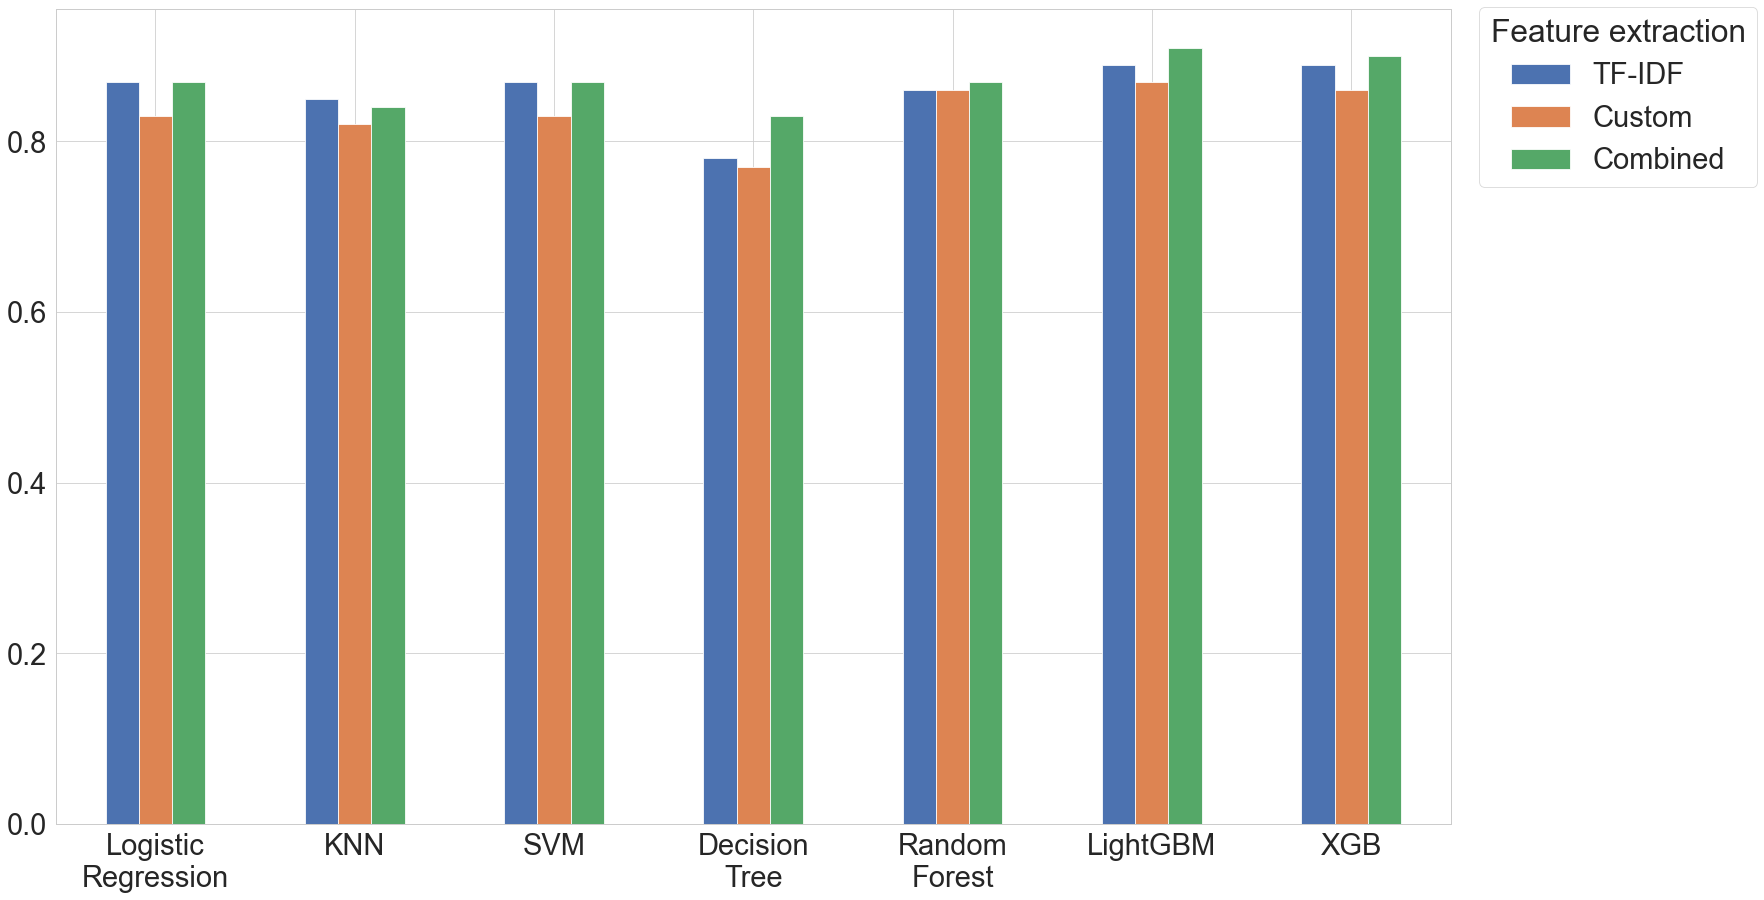

In [35]:
# accuracy plot
sns.set_theme(style="whitegrid")
labels = ['\n'.join(wrap(x, 12)) for x in  models] # custom label multi-line
sns.set_context('paper', font_scale=3.3)
acc_df.T.plot(kind='bar', figsize=(25, 15), rot=0)
plt.xticks(range(len(labels)), labels)
plt.legend(bbox_to_anchor=(1.01, 1.02), loc="upper left", title='Feature extraction')

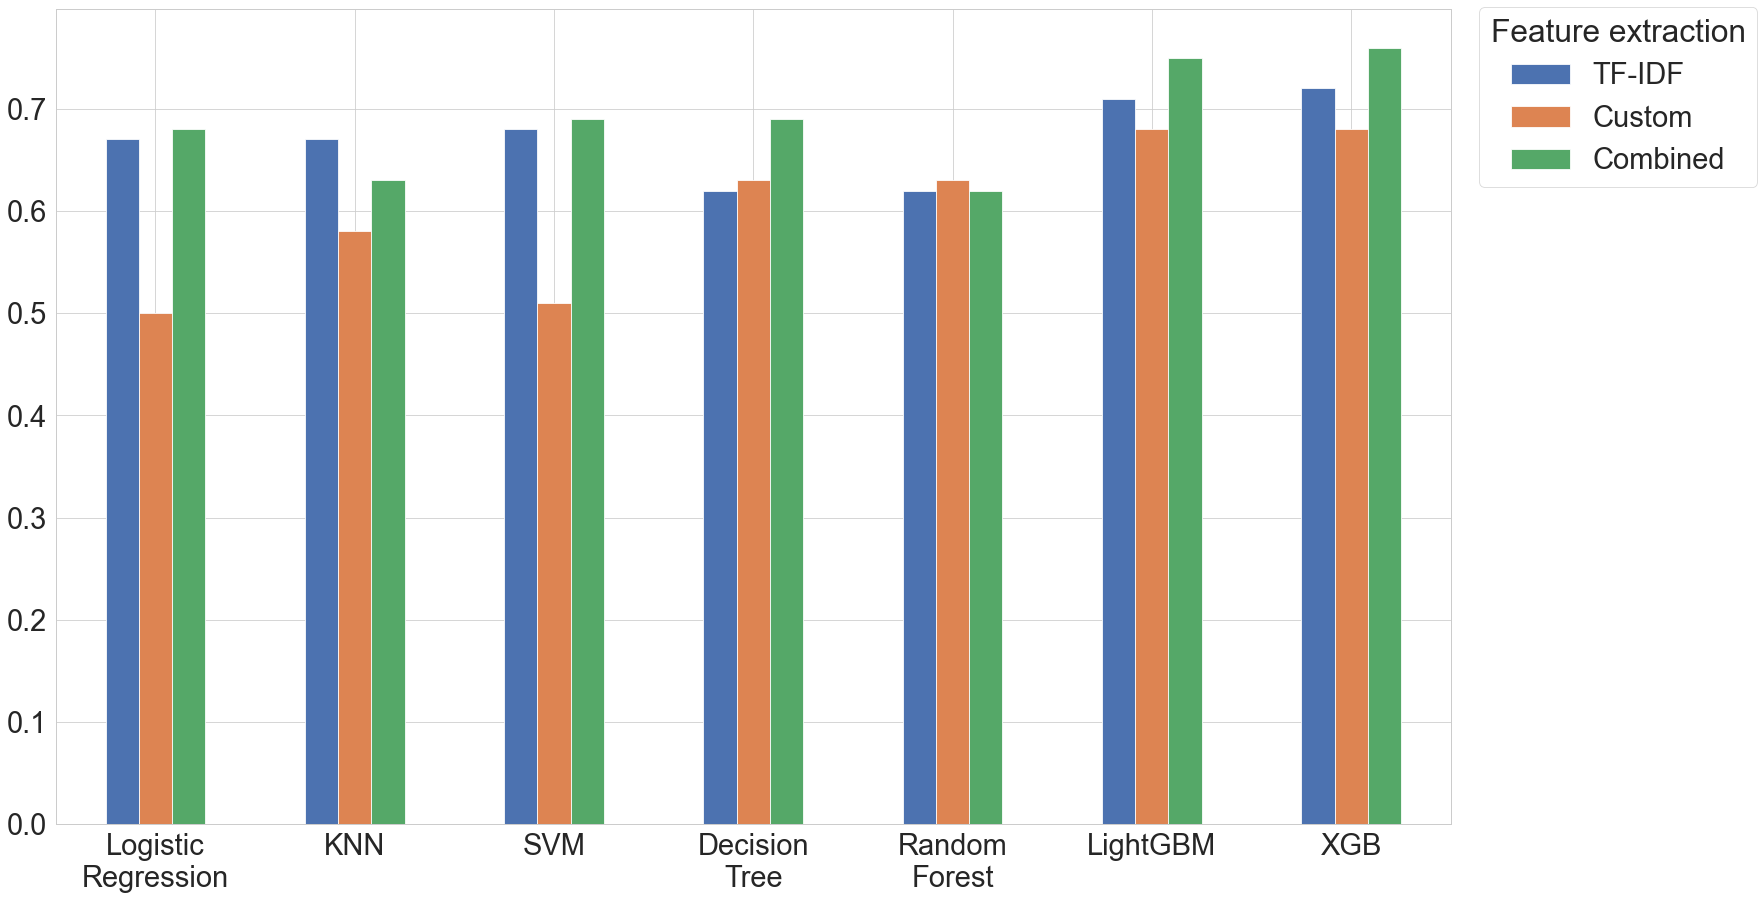

In [36]:
# auc plot
sns.set_context('paper', font_scale=3.3)
auc_df.T.plot(kind='bar', figsize=(25, 15), rot=0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xticks(range(len(labels)), labels)
plt.legend(bbox_to_anchor=(1.01, 1.02), loc="upper left", title='Feature extraction')

# Detection

In [37]:
# choose xgb as it shows the best performance with both 2 scores amongst  
def detect(data):
  # TF-IDF feature
  tfidf = vectorizer.transform([' '.join(tokenize(data[2]))])
  tfidf_svd = svd.transform(tfidf)
  cf = extract_feature(data)
  feature = scaler3.transform([np.append(tfidf_svd, cf)])
  pred = model3_lgbm.predict(feature)
  return pred

In [38]:
def format_detect_input(text, like=0, comment=0, share=0, time=pd.Timestamp(0)):
  inp = [0, 0, text, time, like, share, comment]
  return inp

In [40]:
content = 'Máy bay Vietnam Airlines bị dọa bắn hạ trên vịnh Tokyo. Một máy bay của Vietnam Airlines đã phải chuyển hướng hạ cánh sau cuộc điện thoại có nội dung đe dọa bắn hạ máy bay trên vịnh Tokyo.'
print(content, '\n')
test_input = format_detect_input(content)
print('Nhãn dự đoán là:', detect(test_input))

Máy bay Vietnam Airlines bị dọa bắn hạ trên vịnh Tokyo. Một máy bay của Vietnam Airlines đã phải chuyển hướng hạ cánh sau cuộc điện thoại có nội dung đe dọa bắn hạ máy bay trên vịnh Tokyo. 

Nhãn dự đoán là: [1]
